# Change Point Detection

In [427]:
# If necessary, install:
!pip install statsmodels numpy matplotlib ruptures

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 26.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [428]:
# import libs
import pandas as pd
import numpy as np
import re
import csv
from tqdm import tqdm
from collections import Counter
import matplotlib.dates as mdates
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import matplotlib.lines as mlines
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.api as sm
import ruptures as rpt
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from statsmodels.stats.diagnostic import breaks_cusumolsresid
tqdm.pandas()

# Set width
pd.set_option('display.max_colwidth', 50)

## Load dataset

In [429]:
# load df
df_raw = pd.read_csv('data/df_wikimedia_full_dataset.csv')

In [430]:
# Dataset overview
print(f"Total rows: {len(df_raw)}")
print(f"\nAffiliation breakdown:")
print(df_raw.affiliation.value_counts())

Total rows: 159053

Affiliation breakdown:
affiliation
Republican     84469
Democrat       69678
Independent     3214
Name: count, dtype: int64


In [431]:
# Create party and candidate subsets
df_reps = df_raw[df_raw['affiliation'] == 'Republican'].copy()
df_dems = df_raw[df_raw['affiliation'] == 'Democrat'].copy()
df_inds = df_raw[df_raw['affiliation'] == 'Independent'].copy()
df_trump = df_raw[df_raw['page_title'] == 'Donald Trump'].copy()
df_harris = df_raw[df_raw['page_title'] == 'Kamala Harris'].copy()
df_biden = df_raw[df_raw['page_title'] == 'Joe Biden'].copy()

In [432]:
# function to clean and aggregate dates
def process_dataframe(df):
    # Convert 'date' column to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Set 'date' as the index
    df = df.set_index('timestamp')

    # Select only numeric columns for aggregation
    numeric_columns = df.select_dtypes(include=['number']).columns

    # Group by day and calculate the mean for numeric columns
    df = df[numeric_columns].groupby(pd.Grouper(freq='D')).mean()

    # Reset the index if you need 'date' as a column again
    df = df.reset_index()

    return df

# Apply the function to each DataFrame
df_reps = process_dataframe(df_reps)
df_dems = process_dataframe(df_dems)
df_inds = process_dataframe(df_inds)
df_trump = process_dataframe(df_trump)
df_harris = process_dataframe(df_harris)
df_biden = process_dataframe(df_biden)

In [433]:
# subset for variables of interest
df_reps = df_reps[['timestamp', 'prob_true', 'prob_false']]
df_dems = df_dems[['timestamp', 'prob_true', 'prob_false']]
df_inds = df_inds[['timestamp', 'prob_true', 'prob_false']]
df_trump = df_trump[['timestamp', 'prob_true', 'prob_false']]
df_harris = df_harris[['timestamp', 'prob_true', 'prob_false']]
df_biden = df_biden[['timestamp', 'prob_true', 'prob_false']]

In [434]:
# Rename probability columns for each dataframe
rename_dict = [
    (df_reps, 'reps'),
    (df_dems, 'dems'),
    (df_inds, 'inds'),
    (df_trump, 'trump'),
    (df_harris, 'harris'),
    (df_biden, 'biden')
]

for df, prefix in rename_dict:
    df.rename(columns={'prob_true': f'{prefix}_true', 'prob_false': f'{prefix}_false'}, inplace=True)

In [435]:
# new merging
df_merged1 = pd.merge(df_reps, df_dems, on='timestamp', how='inner')
df_merged2 = pd.merge(df_merged1, df_inds, on='timestamp', how='inner')
len(df_merged2)

1362

In [436]:
# new merging
df_candidates1 = pd.merge(df_trump, df_harris, on='timestamp', how='inner')
df_candidates = pd.merge(df_candidates1, df_biden, on='timestamp', how='inner')
len(df_candidates)

1362

## Change in Point Detection

In [437]:
# Preprocess
df_merged2 = df_merged2.sort_values("timestamp")  # Ensure it's sorted chronologically
df = df_merged2.reset_index(drop=True)

In [438]:
# Convert timestamp column to pandas datetime once
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['time_numeric'] = df['timestamp'].astype('int64') // 10**9  # seconds since epoch

In [439]:
# Target variables as numpy arrays reshaped to 2D
y_dems = df['dems_true'].values.reshape(-1, 1)
y_inds = df['inds_true'].values.reshape(-1, 1)
y_reps = df['reps_true'].values.reshape(-1, 1)

### Fit Models and Break points

In [440]:
# For Dems
y_dems_smooth = pd.Series(y_dems.flatten()).rolling(window=7, center=True).mean().fillna(method='bfill').fillna(method='ffill').values.reshape(-1,1)
model_dems = rpt.Pelt(model="rbf").fit(y_dems_smooth)
break_indices_dems = model_dems.predict(pen=10)

# For Reps
y_reps_smooth = pd.Series(y_reps.flatten()).rolling(window=7, center=True).mean().fillna(method='bfill').fillna(method='ffill').values.reshape(-1,1)
model_reps = rpt.Pelt(model="rbf").fit(y_reps_smooth)
break_indices_reps = model_reps.predict(pen=10)

# For Inds
y_inds_smooth = pd.Series(y_inds.flatten()).rolling(window=7, center=True).mean().fillna(method='bfill').fillna(method='ffill').values.reshape(-1,1)
model_inds = rpt.Pelt(model="rbf").fit(y_inds_smooth)
break_indices_inds = model_inds.predict(pen=10)

/var/folders/dj/mm_8wkz52r7ccy5__rmfvwcjp6kj93/T/ipykernel_8578/638540403.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_dems_smooth = pd.Series(y_dems.flatten()).rolling(window=7, center=True).mean().fillna(method='bfill').fillna(method='ffill').values.reshape(-1,1)
/var/folders/dj/mm_8wkz52r7ccy5__rmfvwcjp6kj93/T/ipykernel_8578/638540403.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_reps_smooth = pd.Series(y_reps.flatten()).rolling(window=7, center=True).mean().fillna(method='bfill').fillna(method='ffill').values.reshape(-1,1)
/var/folders/dj/mm_8wkz52r7ccy5__rmfvwcjp6kj93/T/ipykernel_8578/638540403.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_inds_smooth = pd.Series(y_inds.flatten()).rolling(wind

In [441]:
# define breaks
dem_breaks = [df['timestamp'].iloc[b] for b in break_indices_dems if b < len(df)]
rep_breaks = [df['timestamp'].iloc[b] for b in break_indices_reps if b < len(df)]
ind_breaks = [df['timestamp'].iloc[b] for b in break_indices_inds if b < len(df)]

print(f"Number of Dem breaks: {len(dem_breaks)}")
print("Dem break dates:", dem_breaks)

print(f"\nNumber of Rep breaks: {len(rep_breaks)}")
print("Rep break dates:", rep_breaks)

print(f"\nNumber of Ind breaks: {len(ind_breaks)}")
print("Ind break dates:", ind_breaks)


Number of Dem breaks: 7
Dem break dates: [Timestamp('2020-11-18 00:00:00+0000', tz='UTC'), Timestamp('2021-01-17 00:00:00+0000', tz='UTC'), Timestamp('2021-03-08 00:00:00+0000', tz='UTC'), Timestamp('2021-03-28 00:00:00+0000', tz='UTC'), Timestamp('2021-11-08 00:00:00+0000', tz='UTC'), Timestamp('2022-01-22 00:00:00+0000', tz='UTC'), Timestamp('2024-07-10 00:00:00+0000', tz='UTC')]

Number of Rep breaks: 8
Rep break dates: [Timestamp('2020-12-28 00:00:00+0000', tz='UTC'), Timestamp('2021-03-08 00:00:00+0000', tz='UTC'), Timestamp('2021-07-01 00:00:00+0000', tz='UTC'), Timestamp('2021-09-29 00:00:00+0000', tz='UTC'), Timestamp('2021-10-14 00:00:00+0000', tz='UTC'), Timestamp('2022-04-02 00:00:00+0000', tz='UTC'), Timestamp('2022-05-02 00:00:00+0000', tz='UTC'), Timestamp('2024-07-10 00:00:00+0000', tz='UTC')]

Number of Ind breaks: 13
Ind break dates: [Timestamp('2021-01-22 00:00:00+0000', tz='UTC'), Timestamp('2021-05-02 00:00:00+0000', tz='UTC'), Timestamp('2021-06-06 00:00:00+0000', 

## Party affiliation

In [442]:
# Preprocess
df_merged2 = df_merged2.sort_values("timestamp")  # Ensure it's sorted chronologically
df = df_merged2.reset_index(drop=True)

In [443]:
# Parameter: Change point detection penalty
PENALTY = 10  # Adjust to control sensitivity

In [444]:
# Drop missing and sort data
df = df.dropna(subset=['dems_true', 'reps_true', 'inds_true', 'timestamp']).copy()
df = df.sort_values('timestamp').reset_index(drop=True)

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [445]:
# Prepare target arrays
y_dems = df['dems_true'].values.reshape(-1, 1)
y_reps = df['reps_true'].values.reshape(-1, 1)
y_inds = df['inds_true'].values.reshape(-1, 1)

In [446]:
# --- Apply smoothing (rolling mean) ---
def smooth(signal, window=7):
    ser = pd.Series(signal.flatten())
    return ser.rolling(window=window, center=True).mean().fillna(method='bfill').fillna(method='ffill').values.reshape(-1,1)

y_dems_smooth = smooth(y_dems, window=7)
y_reps_smooth = smooth(y_reps, window=7)
y_inds_smooth = smooth(y_inds, window=7)

/var/folders/dj/mm_8wkz52r7ccy5__rmfvwcjp6kj93/T/ipykernel_8578/3817136197.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return ser.rolling(window=window, center=True).mean().fillna(method='bfill').fillna(method='ffill').values.reshape(-1,1)


In [447]:
# --- Run PELT change point detection ---
def detect_breaks(y_smooth, pen):
    model = rpt.Pelt(model="rbf").fit(y_smooth)
    breaks = model.predict(pen=pen)
    breaks = [i for i in breaks if i < len(y_smooth)]  # Exclude out-of-bounds
    return breaks

break_indices_dems = detect_breaks(y_dems_smooth, PENALTY)
break_indices_reps = detect_breaks(y_reps_smooth, PENALTY)
break_indices_inds = detect_breaks(y_inds_smooth, PENALTY)

dem_breaks = [df['timestamp'].iloc[b] for b in break_indices_dems]
rep_breaks = [df['timestamp'].iloc[b] for b in break_indices_reps]
ind_breaks = [df['timestamp'].iloc[b] for b in break_indices_inds]

In [448]:
# --- Print results ---
print(f"Number of Dem breaks: {len(dem_breaks)}")
print("Dem break dates:", dem_breaks)
print(f"\nNumber of Rep breaks: {len(rep_breaks)}")
print("Rep break dates:", rep_breaks)
print(f"\nNumber of Ind breaks: {len(ind_breaks)}")
print("Ind break dates:", ind_breaks)

Number of Dem breaks: 6
Dem break dates: [Timestamp('2021-11-04 00:00:00+0000', tz='UTC'), Timestamp('2022-07-14 00:00:00+0000', tz='UTC'), Timestamp('2023-02-16 00:00:00+0000', tz='UTC'), Timestamp('2023-06-28 00:00:00+0000', tz='UTC'), Timestamp('2023-08-12 00:00:00+0000', tz='UTC'), Timestamp('2024-05-09 00:00:00+0000', tz='UTC')]

Number of Rep breaks: 2
Rep break dates: [Timestamp('2020-12-28 00:00:00+0000', tz='UTC'), Timestamp('2021-03-07 00:00:00+0000', tz='UTC')]

Number of Ind breaks: 4
Ind break dates: [Timestamp('2021-02-10 00:00:00+0000', tz='UTC'), Timestamp('2021-12-04 00:00:00+0000', tz='UTC'), Timestamp('2022-11-06 00:00:00+0000', tz='UTC'), Timestamp('2023-11-24 00:00:00+0000', tz='UTC')]


In [449]:
def plot_change_points(df, y, break_indices, title, group):
    # Set colors for each group
    color_map = {'Dem': 'blue', 'Rep': 'red', 'Ind': 'gold'}
    color = color_map.get(group, 'black')  # Default to black if not recognized

    plt.figure(figsize=(14, 5))
    plt.plot(df['timestamp'], y, label=f'{group} smoothed value', color=color)

    # Plot vertical lines at each detected change point
    for b in break_indices:
        plt.axvline(df['timestamp'].iloc[b], color=color, linestyle='--', alpha=0.7)

    # Add mean-value segments
    start_idx = 0
    for idx, end_idx in enumerate(break_indices):
        segment_mean = y[start_idx:end_idx].mean()
        plt.hlines(segment_mean,
                   df['timestamp'].iloc[start_idx],
                   df['timestamp'].iloc[end_idx-1],
                   colors=color, linestyles='--', linewidth=2,
                   label='Segment mean' if idx == 0 else "")
        start_idx = end_idx

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()

    # Print detected dates below plot
    detected_dates = [str(df['timestamp'].iloc[b].date()) for b in break_indices]
    dates_text = '\n'.join(detected_dates)
    plt.figtext(0.01, -0.25, f"Detected change point dates:\n{dates_text}",
                ha='left', fontsize=10, wrap=True)

    plt.show()


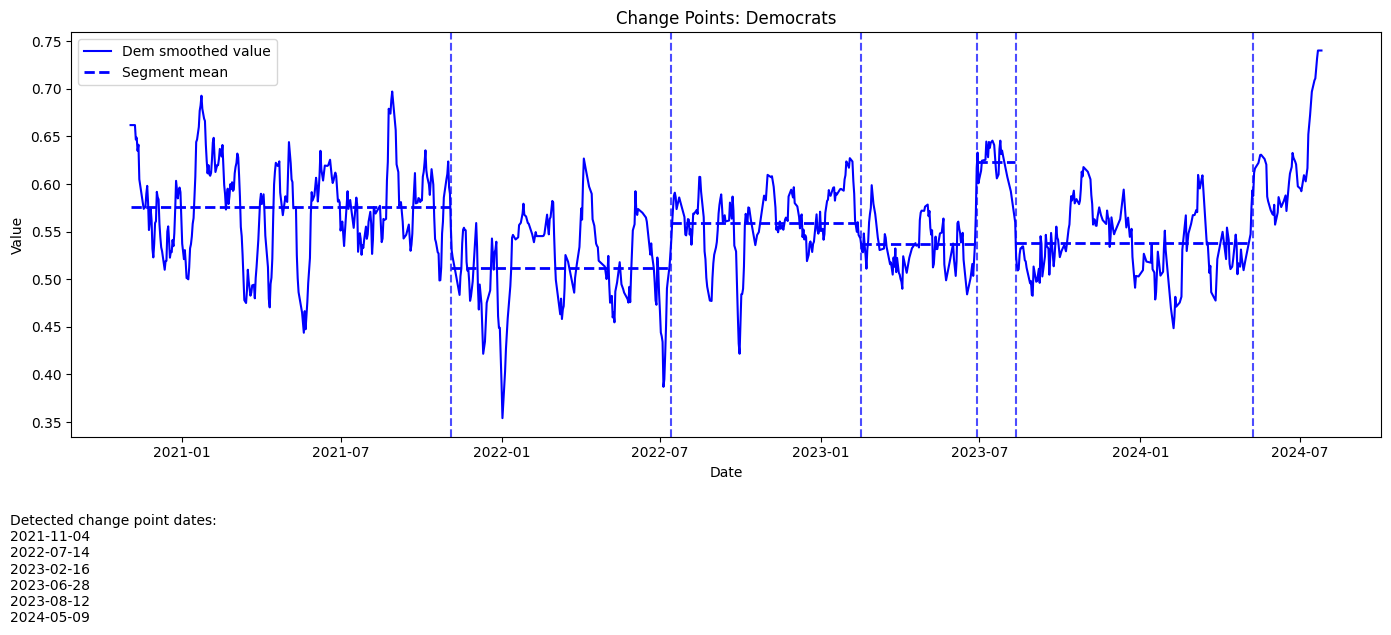

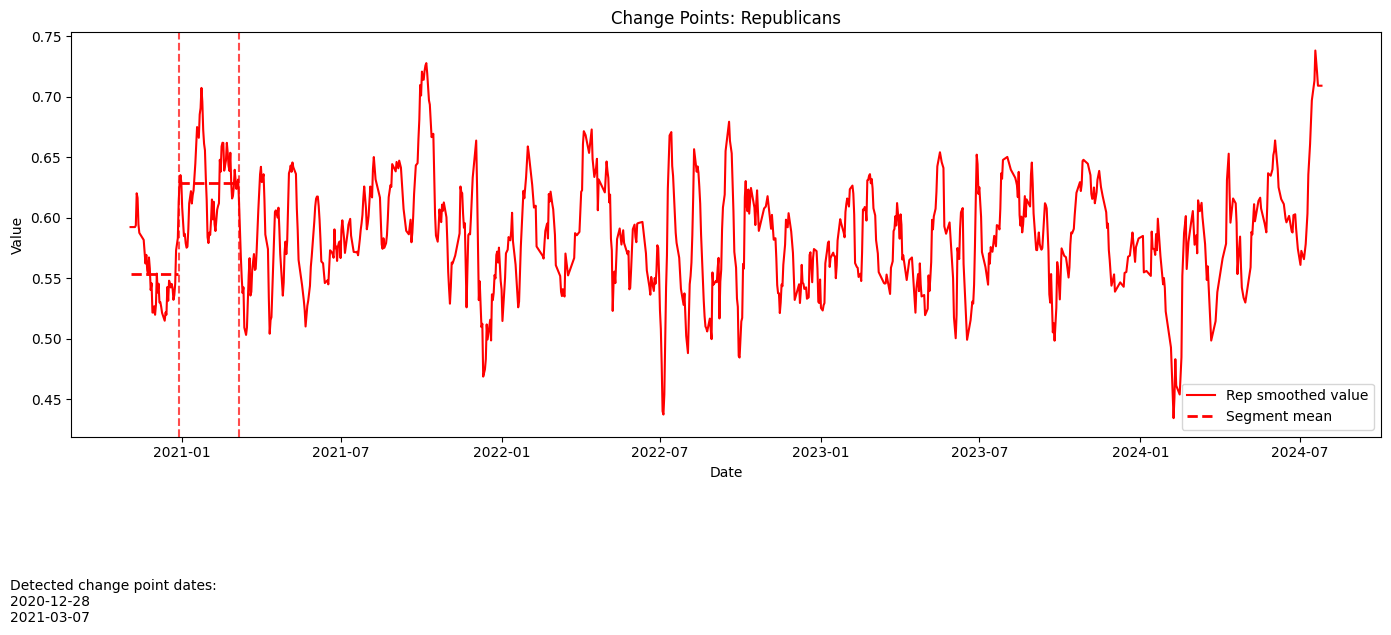

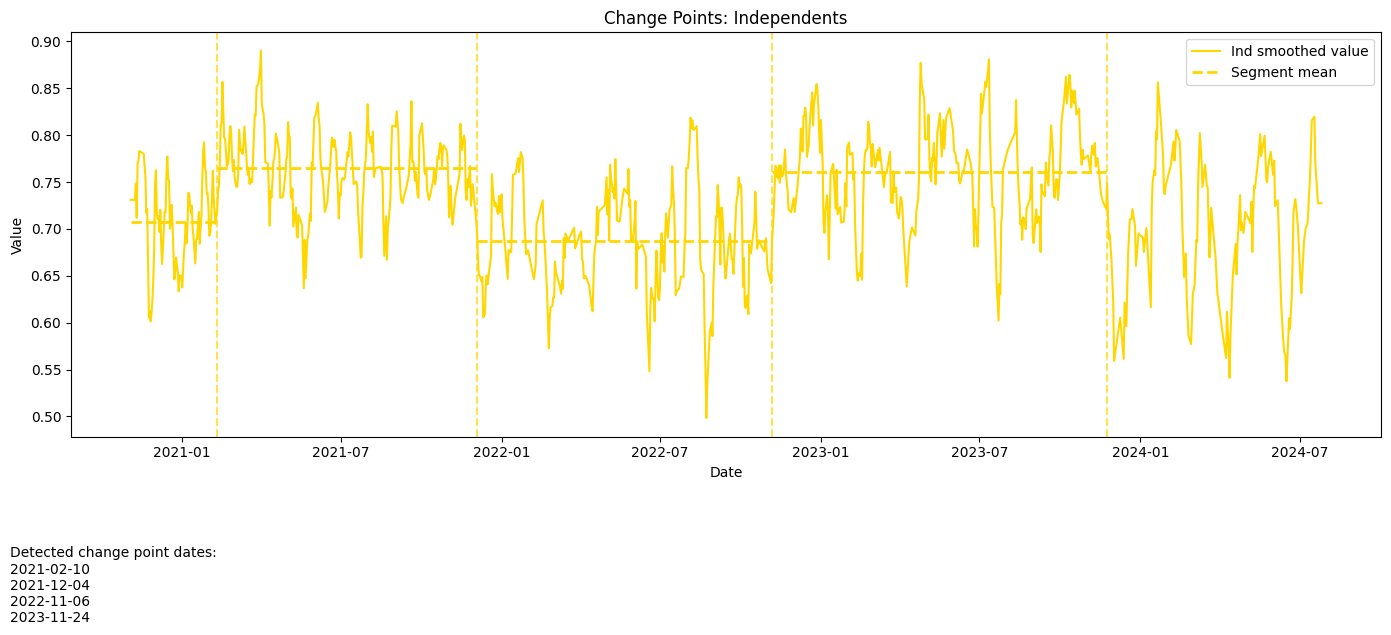

In [450]:
# Visualize
plot_change_points(df, y_dems_smooth, break_indices_dems, "Change Points: Democrats", "Dem")
plot_change_points(df, y_reps_smooth, break_indices_reps, "Change Points: Republicans", "Rep")
plot_change_points(df, y_inds_smooth, break_indices_inds, "Change Points: Independents", "Ind")

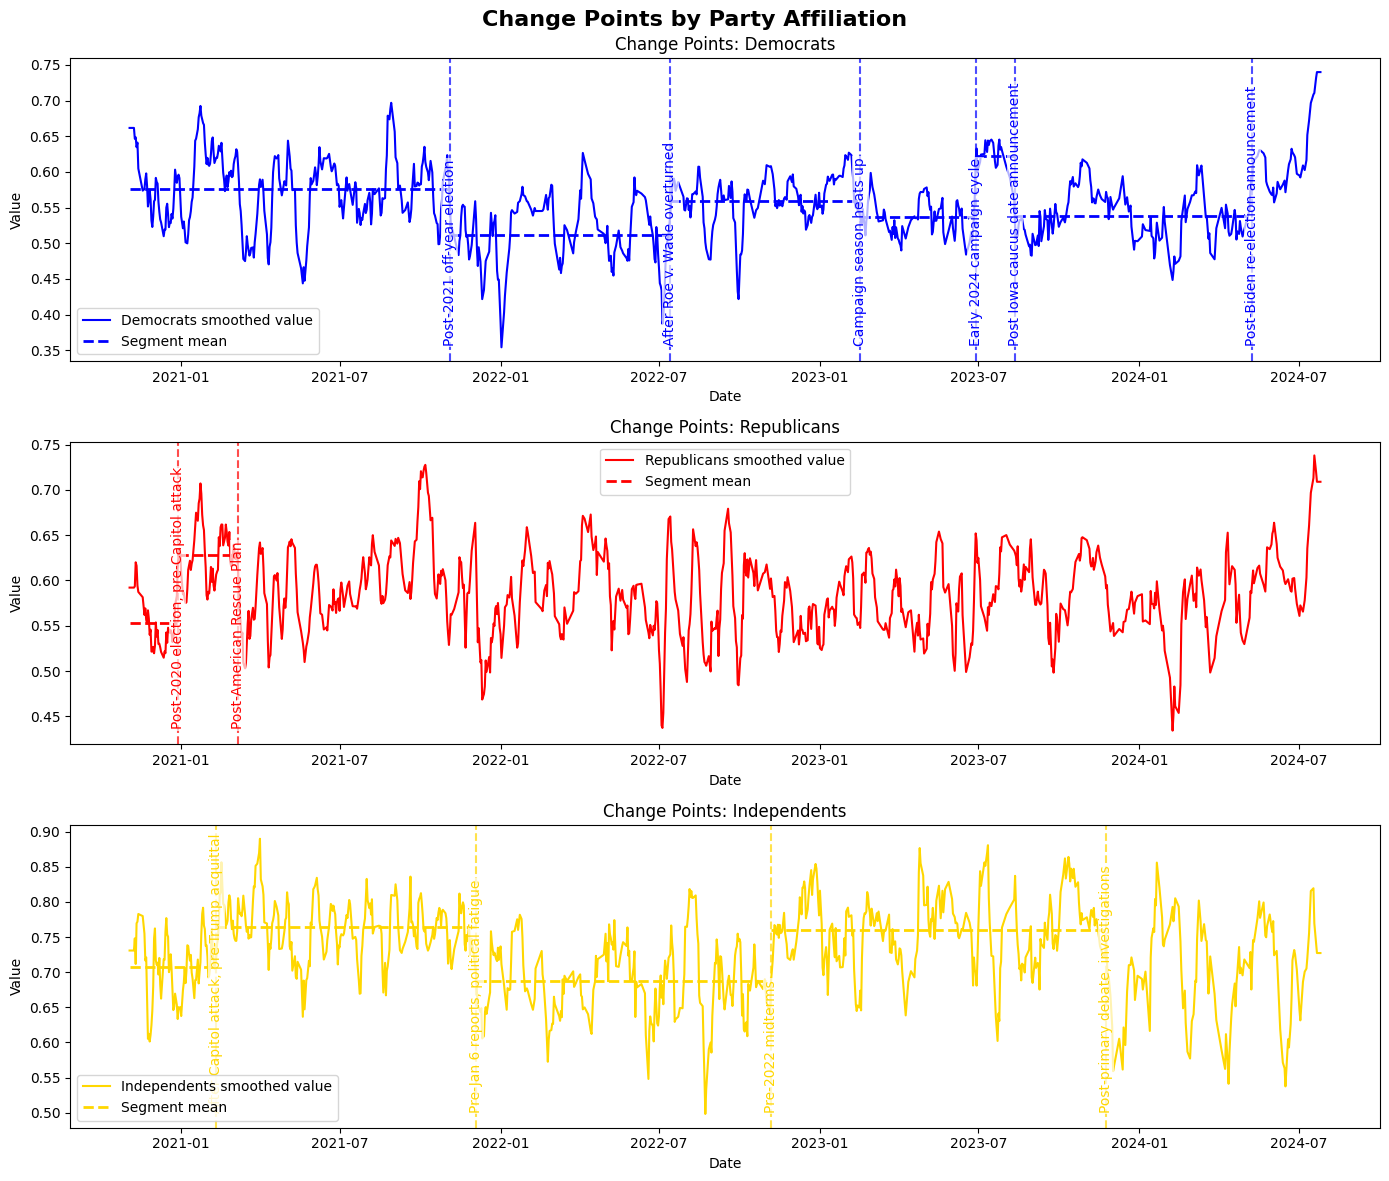

In [451]:
def plot_change_points_combined(df, data_dict, title="Change Points by Party Affiliation"):
    """Plot all party time series with detected change points in one figure."""
    color_map = {'Democrats': 'blue', 'Republicans': 'red', 'Independents': 'gold'}
    
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    for idx, (group, data) in enumerate(data_dict.items()):
        ax = axes[idx]
        y = data['y']
        break_indices = data['break_indices']
        descriptions = data['descriptions']
        color = color_map.get(group, 'black')
        
        # Plot time series
        ax.plot(df['timestamp'], y, label=f'{group} smoothed value', color=color)
        
        # Plot vertical lines at break points
        for b in break_indices:
            ax.axvline(df['timestamp'].iloc[b], color=color, linestyle='--', alpha=0.7)
        
        # Plot segment means
        start_idx = 0
        for i, end_idx in enumerate(break_indices):
            segment_mean = y[start_idx:end_idx].mean()
            ax.hlines(segment_mean,
                     df['timestamp'].iloc[start_idx],
                     df['timestamp'].iloc[end_idx-1],
                     colors=color, linestyles='--', linewidth=2,
                     label='Segment mean' if i == 0 else "")
            start_idx = end_idx
        
        ax.set_xlabel("Date")
        ax.set_ylabel("Value")
        ax.set_title(f"Change Points: {group}", fontsize=12)
        ax.legend()
        
        # Add descriptions if provided
        if descriptions is not None:
            ymin, ymax = ax.get_ylim()
            ypad = (ymax - ymin) * 0.05
            
            for i, b in enumerate(break_indices):
                x = df['timestamp'].iloc[b]
                ax.text(x, ymin + ypad, descriptions[i], rotation=90,
                       verticalalignment='bottom', horizontalalignment='center',
                       color=color, fontsize=10,
                       bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))
    
    plt.tight_layout()
    plt.savefig("figures/change-point-party-affiliation.png", dpi=400, bbox_inches='tight')
    plt.show()


def detect_breaks_from_dates(df, break_dates):
    """Find indices in dataframe corresponding to break dates."""
    breaks = []
    for date in break_dates:
        idx = (df['timestamp'] - date).abs().idxmin()
        breaks.append(idx)
    return breaks


# Ensure timestamps are timezone-aware (convert only if not already aware)
if df['timestamp'].dt.tz is None:
    df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_localize('UTC')
else:
    df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_convert('UTC')

# Define break dates
dem_break_dates = [
    pd.Timestamp('2021-11-04', tz='UTC'),
    pd.Timestamp('2022-07-14', tz='UTC'),
    pd.Timestamp('2023-02-16', tz='UTC'),
    pd.Timestamp('2023-06-28', tz='UTC'),
    pd.Timestamp('2023-08-12', tz='UTC'),
    pd.Timestamp('2024-05-09', tz='UTC'),
]

rep_break_dates = [
    pd.Timestamp('2020-12-28', tz='UTC'),
    pd.Timestamp('2021-03-07', tz='UTC'),
]

ind_break_dates = [
    pd.Timestamp('2021-02-10', tz='UTC'),
    pd.Timestamp('2021-12-04', tz='UTC'),
    pd.Timestamp('2022-11-06', tz='UTC'),
    pd.Timestamp('2023-11-24', tz='UTC'),
]

# Descriptions for each break point
dem_descriptions = [
    "Post-2021 off-year election",
    "After Roe v. Wade overturned",
    "Campaign season heats up",
    "Early 2024 campaign cycle",
    "Post Iowa caucus date announcement",
    "Post-Biden re-election announcement",
]

rep_descriptions = [
    "Post-2020 election, pre-Capitol attack",
    "Post-American Rescue Plan",
]

ind_descriptions = [
    "After Capitol attack, pre-Trump acquittal",
    "Pre-Jan 6 reports, political fatigue",
    "Pre-2022 midterms",
    "Post-primary debate, investigations",
]

# Get break indices from dates
break_indices_dems = detect_breaks_from_dates(df, dem_break_dates)
break_indices_reps = detect_breaks_from_dates(df, rep_break_dates)
break_indices_inds = detect_breaks_from_dates(df, ind_break_dates)

# Prepare smoothed arrays (flatten and trim to match df length)
y_dems_smooth_flat = y_dems_smooth.flatten()[:len(df)]
y_reps_smooth_flat = y_reps_smooth.flatten()[:len(df)]
y_inds_smooth_flat = y_inds_smooth.flatten()[:len(df)]

# Prepare data dictionary
data_dict = {
    'Democrats': {
        'y': y_dems_smooth_flat,
        'break_indices': break_indices_dems,
        'descriptions': dem_descriptions
    },
    'Republicans': {
        'y': y_reps_smooth_flat,
        'break_indices': break_indices_reps,
        'descriptions': rep_descriptions
    },
    'Independents': {
        'y': y_inds_smooth_flat,
        'break_indices': break_indices_inds,
        'descriptions': ind_descriptions
    }
}

# Create combined plot
plot_change_points_combined(df, data_dict)


In [452]:
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu


def format_pvalue(p):
    if p < 0.001:
        return "<0.001"
    elif p < 0.01:
        return "<0.01"
    elif p < 0.05:
        return "<0.05"
    else:
        return f"{p:.3f}"

def format_magnitude(m):
    # Round magnitude, but if very small, just show "~0"
    if abs(m) < 0.001:
        return "~0"
    else:
        return f"{m:.3f}"


def create_summary_table_with_passfail(y_smooth, break_indices, label):
    rows = []
    last_idx = 0
    for b in break_indices:
        if b == 0 or b >= len(y_smooth):
            last_idx = b
            continue
        seg1 = y_smooth[last_idx:b].flatten()
        seg2 = y_smooth[b:].flatten()

        # t-test
        t_stat, t_pval = ttest_ind(seg1, seg2, equal_var=False)
        t_significant = t_pval < 0.05

        # Mann-Whitney U test
        mwu_stat, mwu_pval = mannwhitneyu(seg1, seg2, alternative='two-sided')
        mwu_significant = mwu_pval < 0.05

        # Pass/Fail column
        pass_fail = "Pass" if (t_significant and mwu_significant) else "Fail"

        date = df['timestamp'].iloc[b].date()
        mean_before = seg1.mean()
        mean_after = seg2.mean()
        change = mean_after - mean_before
        direction = "increase" if change > 0 else "decrease"

        rows.append({
            'Group': label,
            'Change Point Index': b,
            'Date': date,
            't-test p-value': format_pvalue(t_pval),
            't-test Significant (95%)': t_significant,
            'Mann-Whitney U p-value': format_pvalue(mwu_pval),
            'Mann-Whitney U Significant (95%)': mwu_significant,
            'Direction': direction,
            'Magnitude': format_magnitude(change),
            'Pass/Fail': pass_fail
        })

        last_idx = b

    return pd.DataFrame(rows)

# Create summary tables for each group including Pass/Fail
summary_dems = create_summary_table_with_passfail(y_dems_smooth, break_indices_dems, 'Democrats')
summary_reps = create_summary_table_with_passfail(y_reps_smooth, break_indices_reps, 'Republicans')
summary_inds = create_summary_table_with_passfail(y_inds_smooth, break_indices_inds, 'Independents')

# Combine all groups
full_summary_with_passfail = pd.concat([summary_dems, summary_reps, summary_inds], ignore_index=True)

# Display the summary
full_summary_with_passfail

# Optionally save to CSV
# full_summary_with_passfail.to_csv('changepoint_summary_with_passfail.csv', index=False)


,Group,Change Point Index,Date,t-test p-value,t-test Significant (95%),Mann-Whitney U p-value,Mann-Whitney U Significant (95%),Direction,Magnitude,Pass/Fail
0,Democrats,290,2021-11-04,<0.001,True,<0.001,True,decrease,-0.030,Pass
1,Democrats,450,2022-07-14,<0.001,True,<0.001,True,increase,0.046,Pass
2,Democrats,605,2023-02-16,0.544,False,<0.05,True,decrease,-0.002,Fail
3,Democrats,690,2023-06-28,<0.001,True,<0.001,True,increase,0.028,Pass
4,Democrats,715,2023-08-12,<0.001,True,<0.001,True,decrease,-0.066,Pass
5,Democrats,870,2024-05-09,<0.001,True,<0.001,True,increase,0.087,Pass
6,Republicans,45,2020-12-28,<0.001,True,<0.001,True,increase,0.033,Pass
7,Republicans,110,2021-03-07,<0.001,True,<0.001,True,decrease,-0.045,Pass
8,Independents,85,2021-02-10,<0.001,True,<0.001,True,increase,0.025,Pass
9,Independents,310,2021-12-04,<0.001,True,<0.001,True,decrease,-0.044,Pass


## Candidates

In [453]:
# Preprocess
df_candidates = df_candidates.sort_values("timestamp")  # Ensure it's sorted chronologically
df = df_candidates.reset_index(drop=True)

In [454]:
# Parameter: Change point detection penalty
PENALTY = 10  # Adjust to control sensitivity

In [455]:
# Drop missing and sort data
df = df.dropna(subset=['biden_true', 'trump_true', 'harris_true', 'timestamp']).copy()
df = df.sort_values('timestamp').reset_index(drop=True)

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [456]:
# Prepare target arrays
y_biden = df['biden_true'].values.reshape(-1, 1)
y_trump = df['trump_true'].values.reshape(-1, 1)
y_harris = df['harris_true'].values.reshape(-1, 1)

In [457]:
# --- Apply smoothing (rolling mean) ---
def smooth(signal, window=7):
    ser = pd.Series(signal.flatten())
    return ser.rolling(window=window, center=True).mean().fillna(method='bfill').fillna(method='ffill').values.reshape(-1,1)

y_biden_smooth = smooth(y_biden, window=7)
y_trump_smooth = smooth(y_trump, window=7)
y_harris_smooth = smooth(y_harris, window=7)

/var/folders/dj/mm_8wkz52r7ccy5__rmfvwcjp6kj93/T/ipykernel_8578/1857020192.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return ser.rolling(window=window, center=True).mean().fillna(method='bfill').fillna(method='ffill').values.reshape(-1,1)


In [458]:
# --- Run PELT change point detection ---
def detect_breaks(y_smooth, pen):
    model = rpt.Pelt(model="rbf").fit(y_smooth)
    breaks = model.predict(pen=pen)
    breaks = [i for i in breaks if i < len(y_smooth)]  # Exclude out-of-bounds
    return breaks

break_indices_biden = detect_breaks(y_biden_smooth, PENALTY)
break_indices_trump = detect_breaks(y_trump_smooth, PENALTY)
break_indices_harris = detect_breaks(y_harris_smooth, PENALTY)

biden_breaks = [df['timestamp'].iloc[b] for b in break_indices_biden]
trump_breaks = [df['timestamp'].iloc[b] for b in break_indices_trump]
harris_breaks = [df['timestamp'].iloc[b] for b in break_indices_harris]

In [459]:
# --- Print results ---
print(f"Number of Biden breaks: {len(biden_breaks)}")
print("Biden break dates:", biden_breaks)
print(f"\nNumber of Trump breaks: {len(trump_breaks)}")
print("Trump break dates:", trump_breaks)
print(f"\nNumber of Harris breaks: {len(break_indices_harris)}")
print("Harris break dates:", break_indices_harris)

Number of Biden breaks: 3
Biden break dates: [Timestamp('2021-01-07 00:00:00+0000', tz='UTC'), Timestamp('2021-04-28 00:00:00+0000', tz='UTC'), Timestamp('2021-12-07 00:00:00+0000', tz='UTC')]

Number of Trump breaks: 3
Trump break dates: [Timestamp('2020-12-25 00:00:00+0000', tz='UTC'), Timestamp('2021-03-01 00:00:00+0000', tz='UTC'), Timestamp('2023-07-07 00:00:00+0000', tz='UTC')]

Number of Harris breaks: 1
Harris break dates: [20]


In [460]:
def plot_change_points(df, y, break_indices, title, group):
    # Set colors for each group
    color_map = {'Biden': 'dodgerblue', 'Trump': 'red', 'Harris': 'blue'}
    color = color_map.get(group, 'black')  # Default to black if not recognized

    plt.figure(figsize=(14, 5))
    plt.plot(df['timestamp'], y, label=f'{group} smoothed value', color=color)

    # Plot vertical lines at each detected change point
    for b in break_indices:
        plt.axvline(df['timestamp'].iloc[b], color=color, linestyle='--', alpha=0.7)

    # Add mean-value segments
    start_idx = 0
    for idx, end_idx in enumerate(break_indices):
        segment_mean = y[start_idx:end_idx].mean()
        plt.hlines(segment_mean,
                   df['timestamp'].iloc[start_idx],
                   df['timestamp'].iloc[end_idx-1],
                   colors=color, linestyles='--', linewidth=2,
                   label='Segment mean' if idx == 0 else "")
        start_idx = end_idx

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()

    # Print detected dates below plot
    detected_dates = [str(df['timestamp'].iloc[b].date()) for b in break_indices]
    dates_text = '\n'.join(detected_dates)
    plt.figtext(0.01, -0.19, f"Detected change point dates:\n{dates_text}",
                ha='left', fontsize=10, wrap=True)

    plt.show()


In [461]:
# --- Run PELT change point detection ---
def detect_breaks(y_smooth, pen):
    model = rpt.Pelt(model="rbf").fit(y_smooth)
    breaks = model.predict(pen=pen)
    breaks = [i for i in breaks if i < len(y_smooth)]  # Exclude out-of-bounds
    return breaks

break_indices_biden = detect_breaks(y_biden_smooth, PENALTY)
break_indices_trump = detect_breaks(y_trump_smooth, PENALTY)
break_indices_harris = detect_breaks(y_harris_smooth, PENALTY)

biden_breaks = [df['timestamp'].iloc[b] for b in break_indices_biden]
trump_breaks = [df['timestamp'].iloc[b] for b in break_indices_trump]
harris_breaks = [df['timestamp'].iloc[b] for b in break_indices_harris]

In [462]:
def plot_change_points_with_events(df, y, break_indices, title, group, events):
    color_map = {'Dem': 'blue', 'Rep': 'red', 'Ind': 'gold'}
    color = color_map.get(group, 'black')

    plt.figure(figsize=(14, 5))
    plt.plot(df['timestamp'], y, label=f'{group} smoothed value', color=color)

    for b in break_indices:
        plt.axvline(df['timestamp'].iloc[b], color=color, linestyle='--', alpha=0.7)

    # Draw segment means
    start_idx = 0
    for idx, end_idx in enumerate(break_indices):
        segment_mean = y[start_idx:end_idx].mean()
        plt.hlines(segment_mean,
                   df['timestamp'].iloc[start_idx],
                   df['timestamp'].iloc[end_idx-1],
                   colors=color, linestyles='--', linewidth=2,
                   label='Segment mean' if idx == 0 else "")
        start_idx = end_idx

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Revert Risk")

    # Add event annotations
    for b in break_indices:
        date_str = str(df['timestamp'].iloc[b].date())
        event_label = events.get(date_str, None)
        if event_label:
            plt.annotate(event_label,
                         (df['timestamp'].iloc[b], y[b]),
                         xytext=(0, 15), textcoords='offset points',
                         arrowprops=dict(facecolor=color, arrowstyle='->'),
                         fontsize=9, color=color)

    plt.legend()
    plt.tight_layout()

    detected_dates = [str(df['timestamp'].iloc[b].date()) for b in break_indices]
    dates_text = '\n'.join(detected_dates)
    plt.figtext(0.01, 0, f"Detected change point dates:\n{dates_text}",
                ha='left', fontsize=10, wrap=True)

    plt.show()


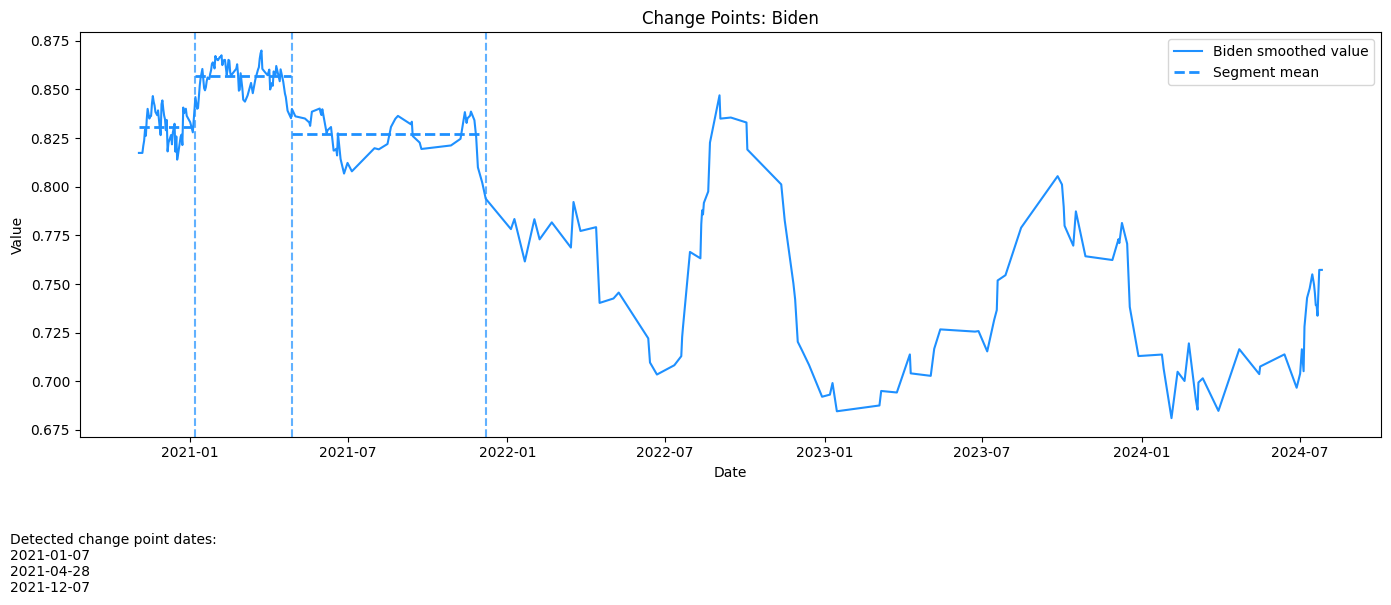

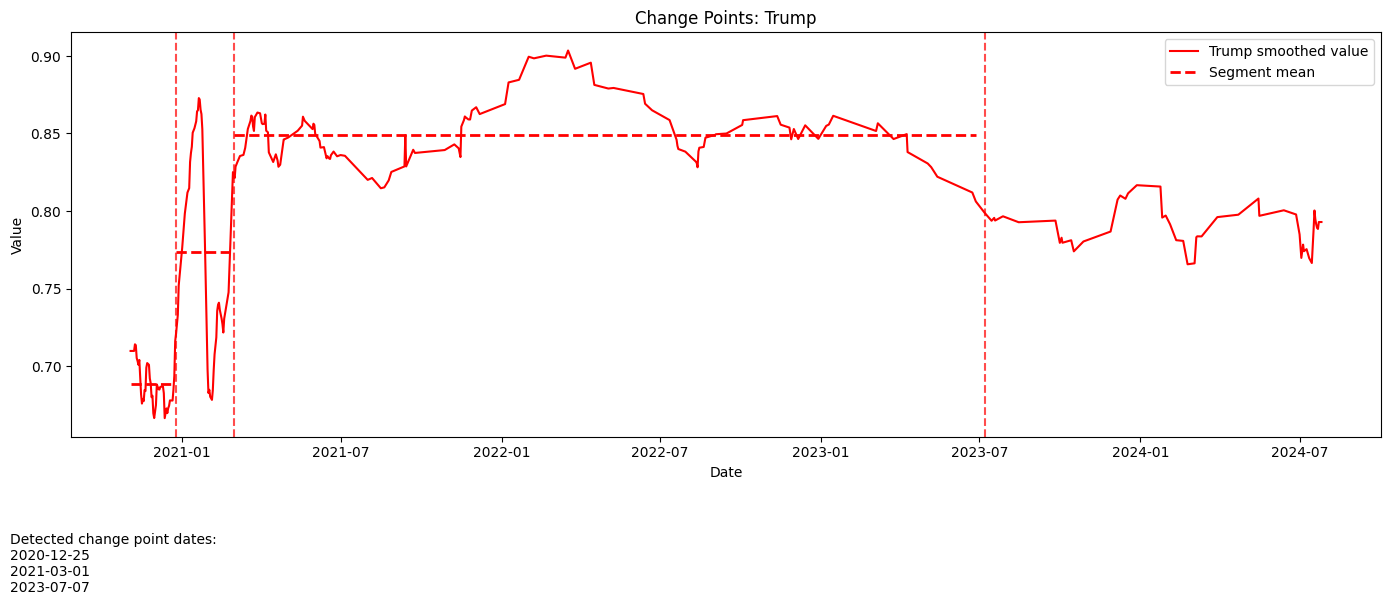

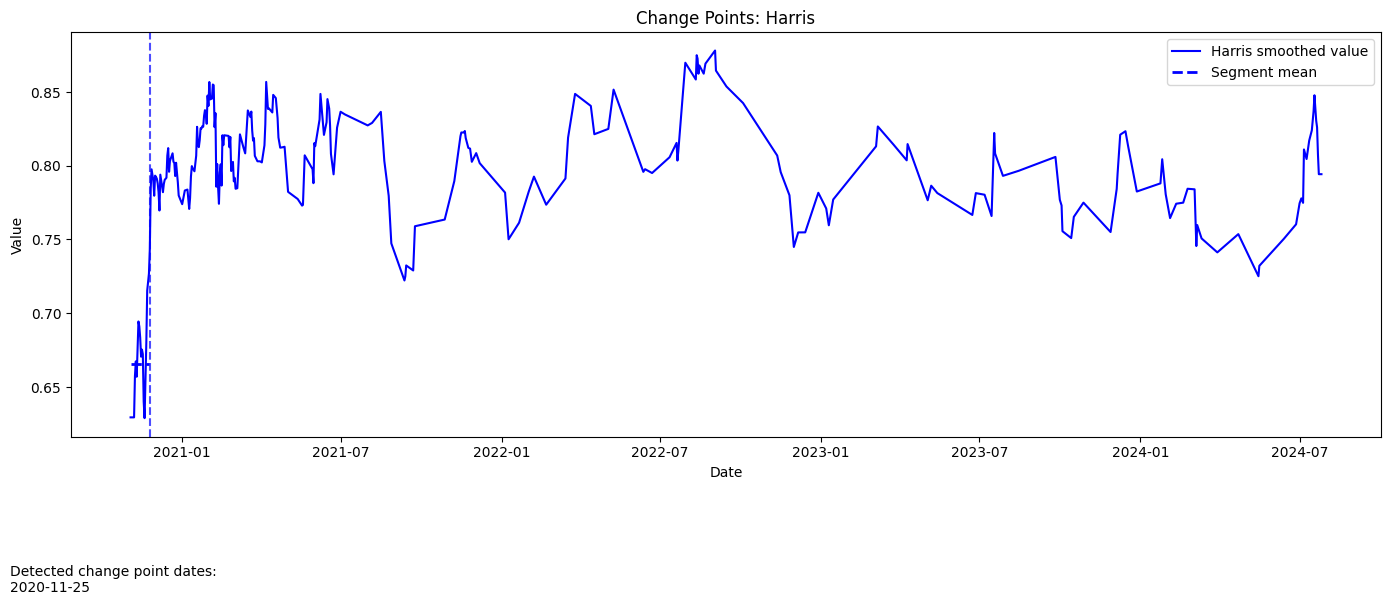

In [463]:
# Visualize
plot_change_points(df, y_biden_smooth, break_indices_biden, "Change Points: Biden", "Biden")
plot_change_points(df, y_trump_smooth, break_indices_trump, "Change Points: Trump", "Trump")
plot_change_points(df, y_harris_smooth, break_indices_harris, "Change Points: Harris", "Harris")

In [464]:
# --- Updated break dates with tz-aware timestamps ---
biden_break_dates = [
    pd.Timestamp('2021-01-07', tz='UTC'),
    pd.Timestamp('2021-04-28', tz='UTC'),
    pd.Timestamp('2021-12-07', tz='UTC'),
]

trump_break_dates = [
    pd.Timestamp('2020-12-25', tz='UTC'),
    pd.Timestamp('2021-03-01', tz='UTC'),
    pd.Timestamp('2023-07-07', tz='UTC'),
]

harris_break_dates = [
    pd.Timestamp('2020-11-25', tz='UTC'),  # Updated date
]

# --- Event descriptions keyed by date strings ---
biden_events = {
    '2021-01-07': 'Post-Capitol attack',
    '2021-04-28': 'After vaccine rollout acceleration',
    '2021-12-07': 'Before midterm campaign season',
}

trump_events = {
    '2020-12-25': 'Christmas after 2020 election',
    '2021-03-01': 'Post-American Rescue Plan debate',
    '2023-07-07': 'After major investigations',
}

harris_events = {
    '2020-11-25': 'After 2020 election',
}

In [465]:
# --- Detect breaks using PELT method ---
def detect_breaks(y_smooth, pen):
    model = rpt.Pelt(model="rbf").fit(y_smooth)
    breaks = model.predict(pen=pen)
    breaks = [i for i in breaks if i < len(y_smooth)]  # Exclude out-of-bounds
    return breaks

In [466]:
# --- Run PELT change point detection ---
def detect_breaks(y_smooth, pen):
    model = rpt.Pelt(model="rbf").fit(y_smooth)
    breaks = model.predict(pen=pen)
    breaks = [i for i in breaks if i < len(y_smooth)]  # Exclude out-of-bounds
    return breaks

break_indices_biden = detect_breaks(y_biden_smooth, PENALTY)
break_indices_trump = detect_breaks(y_trump_smooth, PENALTY)
break_indices_harris = detect_breaks(y_harris_smooth, PENALTY)

biden_breaks = [df['timestamp'].iloc[b] for b in break_indices_biden]
trump_breaks = [df['timestamp'].iloc[b] for b in break_indices_trump]
harris_breaks = [df['timestamp'].iloc[b] for b in break_indices_harris]

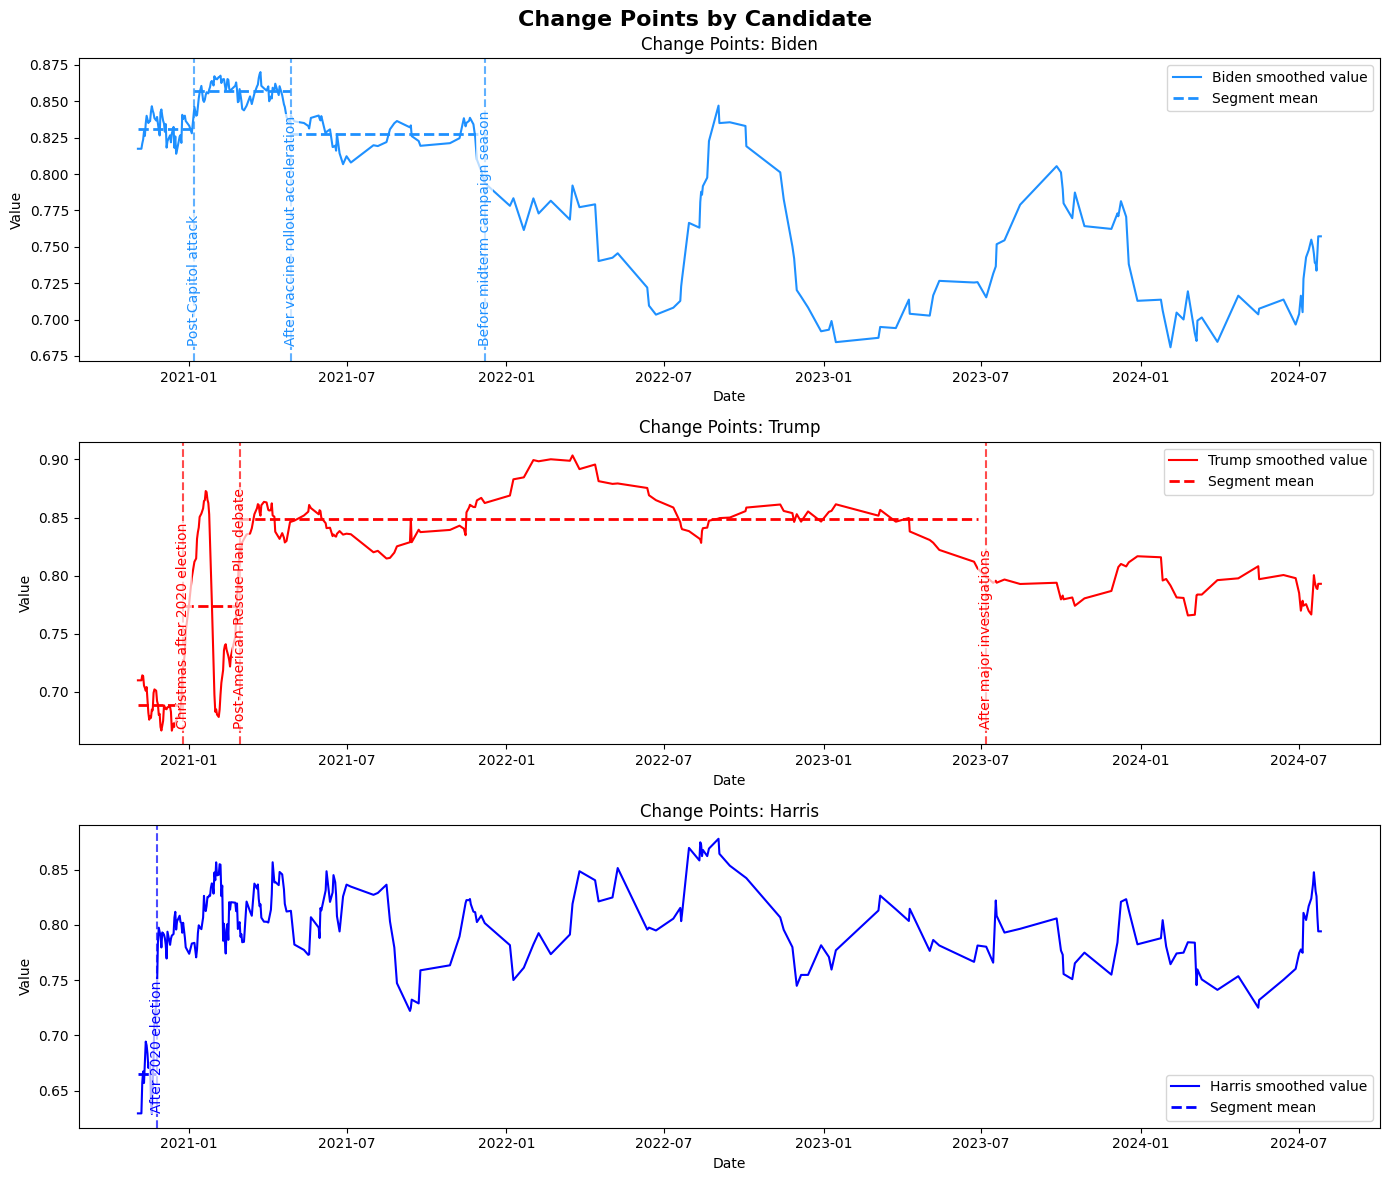

In [467]:
def get_break_indices(df, break_dates):
    """Map break dates to indices in dataframe."""
    indices = []
    for date in break_dates:
        idx = df.index[df['timestamp'] == date]
        if not idx.empty:
            indices.append(idx[0])
        else:
            print(f"Warning: date {date} not found in dataframe timestamps")
    return indices


def plot_change_points_candidates_combined(df, data_dict, title="Change Points by Candidate"):
    """Plot all candidate time series with detected change points in one figure."""
    color_map = {'Biden': 'dodgerblue', 'Trump': 'red', 'Harris': 'blue'}
    
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    for idx, (group, data) in enumerate(data_dict.items()):
        ax = axes[idx]
        y = data['y']
        break_indices = data['break_indices']
        events = data['events']
        color = color_map.get(group, 'black')
        
        # Plot time series
        ax.plot(df['timestamp'], y, label=f'{group} smoothed value', color=color)
        
        # Plot vertical lines at break points
        for b in break_indices:
            ax.axvline(df['timestamp'].iloc[b], color=color, linestyle='--', alpha=0.7)
        
        # Plot segment means
        start_idx = 0
        for i, end_idx in enumerate(break_indices):
            segment_mean = y[start_idx:end_idx].mean()
            ax.hlines(segment_mean,
                     df['timestamp'].iloc[start_idx],
                     df['timestamp'].iloc[end_idx-1],
                     colors=color, linestyles='--', linewidth=2,
                     label='Segment mean' if i == 0 else "")
            start_idx = end_idx
        
        ax.set_xlabel("Date")
        ax.set_ylabel("Value")
        ax.set_title(f"Change Points: {group}", fontsize=12)
        ax.legend()
        
        # Add event annotations
        ymin, ymax = ax.get_ylim()
        ypad = (ymax - ymin) * 0.05
        
        for b in break_indices:
            date_str = str(df['timestamp'].iloc[b].date())
            event_label = events.get(date_str, None)
            if event_label:
                ax.text(df['timestamp'].iloc[b], ymin + ypad, event_label,
                       rotation=90, verticalalignment='bottom', 
                       horizontalalignment='center', color=color, fontsize=10,
                       bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))
    
    plt.tight_layout()
    plt.savefig("figures/change-point-candidates.png", dpi=400, bbox_inches='tight')
    plt.show()


# Ensure timestamps are timezone-aware
if df['timestamp'].dt.tz is None:
    df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_localize('UTC')
else:
    df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_convert('UTC')

# Get break indices for each candidate
break_indices_biden = get_break_indices(df, biden_break_dates)
break_indices_trump = get_break_indices(df, trump_break_dates)
break_indices_harris = get_break_indices(df, harris_break_dates)

# Prepare smoothed arrays (flatten and trim to match df length)
y_biden_smooth_flat = y_biden_smooth.flatten()[:len(df)]
y_trump_smooth_flat = y_trump_smooth.flatten()[:len(df)]
y_harris_smooth_flat = y_harris_smooth.flatten()[:len(df)]

# Prepare data dictionary
data_dict = {
    'Biden': {
        'y': y_biden_smooth_flat,
        'break_indices': break_indices_biden,
        'events': biden_events
    },
    'Trump': {
        'y': y_trump_smooth_flat,
        'break_indices': break_indices_trump,
        'events': trump_events
    },
    'Harris': {
        'y': y_harris_smooth_flat,
        'break_indices': break_indices_harris,
        'events': harris_events
    }
}

# Create combined plot
plot_change_points_candidates_combined(df, data_dict)


In [469]:
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu


def format_pvalue(p):
    if p < 0.001:
        return "<0.001"
    elif p < 0.01:
        return "<0.01"
    elif p < 0.05:
        return "<0.05"
    else:
        return f"{p:.3f}"

def format_magnitude(m):
    # Round magnitude, but if very small, just show "~0"
    if abs(m) < 0.001:
        return "~0"
    else:
        return f"{m:.3f}"


def create_summary_table_with_passfail(y_smooth, break_indices, label):
    rows = []
    last_idx = 0
    for b in break_indices:
        if b == 0 or b >= len(y_smooth):
            last_idx = b
            continue
        seg1 = y_smooth[last_idx:b].flatten()
        seg2 = y_smooth[b:].flatten()

        # t-test
        t_stat, t_pval = ttest_ind(seg1, seg2, equal_var=False)
        t_significant = t_pval < 0.05

        # Mann-Whitney U test
        mwu_stat, mwu_pval = mannwhitneyu(seg1, seg2, alternative='two-sided')
        mwu_significant = mwu_pval < 0.05

        # Pass/Fail column
        pass_fail = "Pass" if (t_significant and mwu_significant) else "Fail"

        date = df['timestamp'].iloc[b].date()
        mean_before = seg1.mean()
        mean_after = seg2.mean()
        change = mean_after - mean_before
        direction = "increase" if change > 0 else "decrease"

        rows.append({
            'Group': label,
            'Change Point Index': b,
            'Date': date,
            't-test p-value': format_pvalue(t_pval),
            't-test Significant (95%)': t_significant,
            'Mann-Whitney U p-value': format_pvalue(mwu_pval),
            'Mann-Whitney U Significant (95%)': mwu_significant,
            'Direction': direction,
            'Magnitude': format_magnitude(change),
            'Pass/Fail': pass_fail
        })

        last_idx = b

    return pd.DataFrame(rows)

# Create summary tables for each group including Pass/Fail
summary_biden = create_summary_table_with_passfail(y_biden_smooth, break_indices_biden, 'Biden')
summary_trump = create_summary_table_with_passfail(y_trump_smooth, break_indices_trump, 'Trump')
summary_harris = create_summary_table_with_passfail(y_harris_smooth, break_indices_harris, 'Harris')

# Combine all groups
full_summary_with_passfail = pd.concat([summary_biden, summary_trump, summary_harris], ignore_index=True)

# Display the summary
full_summary_with_passfail

# Optionally save to CSV
# full_summary_with_passfail.to_csv('changepoint_summary_with_passfail.csv', index=False)


,Group,Change Point Index,Date,t-test p-value,t-test Significant (95%),Mann-Whitney U p-value,Mann-Whitney U Significant (95%),Direction,Magnitude,Pass/Fail
0,Biden,50,2021-01-07,<0.001,True,0.067,False,decrease,-0.033,Fail
1,Biden,125,2021-04-28,<0.001,True,<0.001,True,decrease,-0.088,Pass
2,Biden,170,2021-12-07,<0.001,True,<0.001,True,decrease,-0.083,Pass
3,Trump,45,2020-12-25,<0.001,True,<0.001,True,increase,0.131,Pass
4,Trump,95,2021-03-01,<0.001,True,<0.001,True,increase,0.058,Pass
5,Trump,225,2023-07-07,<0.001,True,<0.001,True,decrease,-0.059,Pass
6,Harris,20,2020-11-25,<0.001,True,<0.001,True,increase,0.138,Pass
